# Implements

In [2]:
import os
from pathlib import Path
import numpy as np
# from keras import backend as K
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [26]:
physical_device = tf.config.experimental.list_physical_devices('GPU')
print(f'Device found : {physical_device}')

CH_CODE = ["CONV_2_1_3", "CONV_2_1_4", "CONV_2_1_5"]
classes = CH_CODE
snrs = list(range(-5, 21, 1))

Device found : []


# Define Funtions

In [4]:
def train(model):
    resume = True
    filepath = "best_model.keras"  # 저장할 모델 파일명
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                                 save_best_only=True, mode='max')
    earlystopping = EarlyStopping(monitor='val_accuracy', patience=20, verbose=2)
    callbacks_list = [checkpoint, earlystopping]
    history = model.fit(x_train, y_train, epochs=200, batch_size=256, verbose=1, # batch_size=1024 -> 256
                            # validation_data=(x_test, y_test),
                            validation_data=(x_val, y_val),
                            callbacks=callbacks_list)
    score = model.evaluate(x_test, y_test, verbose=1)
    print('Baseline Error: %.2f%%' % (100 - score[1] * 100))
    
    return history

In [6]:
def test(model):
    acc = {}
    for snr in snrs:
        test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
        test_X_i = x_test[np.where(np.array(test_SNRs) == str(snr))]
        test_Y_i = y_test[np.where(np.array(test_SNRs) == str(snr))]
        
        print(test_X_i)
        print(test_X_i.shape)
                
        print(f"\nTesting at SNR {snr} dB:")
        test_Y_i_hat = model.predict(test_X_i)
        
        conf = np.zeros([len(classes), len(classes)])
        for i in range(test_X_i.shape[0]):
            j = list(test_Y_i[i, :]).index(1)
            k = int(np.argmax(test_Y_i_hat[i, :]))
            conf[j, k] += 1
        
        confnorm = conf / np.sum(conf, axis=1, keepdims=True)
        
        cor = np.sum(np.diag(conf))
        ncor = np.sum(conf) - cor
        accuracy = cor / (cor + ncor)
        print(f"Overall Accuracy: {accuracy}")
        
        acc[snr] = accuracy
    
    # Plot accuracy by SNR
    plt.figure()
    plt.plot(snrs, [acc[snr] for snr in snrs], marker='o')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Accuracy')
    plt.title('Classification Accuracy by SNR')
    plt.grid(True)
    plt.show()

In [7]:
def calc_confusion_matrix(model, x_test):
    y_predict = model.predict(x_test)

    # Calculate confusion matrix
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,x_test.shape[0]):
        j = list(y_test[i,:]).index(1)
        k = int(np.argmax(y_predict[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
    return confnorm

In [80]:
def plot_confusion_matrix(cm, results_dir, labels=[], title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    result_image_path = os.path.join(results_dir, 'conf_mat.png')
    plt.savefig(result_image_path)

In [88]:
def SNR_accuracy(in_snr, model, name, x_test, y_test, results_dir):
    acc = []
    for snr in in_snr:
        idx_acc_snr = [i for i in range(len(test_idx)) if lbl[test_idx[i]][1] == snr]
        acc_X_test = x_test[idx_acc_snr]
        acc_Y_test = y_test[idx_acc_snr]
        
        print('\nSNR ' + str(snr) + 'dB:')
        accuracy_snr = model.evaluate(acc_X_test, acc_Y_test, batch_size=32, verbose=2)
        acc.append(accuracy_snr)
    acc = np.vstack(acc)
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(in_snr, (acc[:,1]*100), 'steelblue', marker='.', markersize=15, label=name, linestyle='-')
    ax.legend(loc=4, prop={'size': 25})
    
    ax.set_xticks(np.arange(-5, 21, 1))
    ax.set_yticks(np.arange(0, 101, 10))
    
    ax.grid(which='both', color='lightgray', linestyle='-')
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    
    ax.set_xlim(-5, 21)
    ax.set_ylim(0, 100)
    
    ax.set_title("Classification Accuracy", fontsize=20)
    ax.set_ylabel('Accuracy (%)', fontsize=20)
    ax.set_xlabel('SNR (dB)', fontsize=20)
    
    result_image_path = os.path.join(results_dir, 'snr_acc.png')
    plt.savefig(result_image_path)
    
    plt.show()

    return acc[:,1]

## KAN

In [91]:
import tensorflow as tf
import numpy as np

class KANLinear(tf.keras.layers.Layer):
    def __init__(
        self,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=tf.nn.silu,
        grid_eps=0.02,
        grid_range=(-1, 1),
        **kwargs
    ):
        super(KANLinear, self).__init__(**kwargs)
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = tf.expand_dims(tf.range(-spline_order, grid_size + spline_order + 1, dtype=tf.float32) * h + grid_range[0], axis=0)
        self.grid = self.add_weight("grid", shape=grid.shape, initializer=tf.constant_initializer(grid.numpy()), trainable=False)

        self.base_weight = self.add_weight("base_weight", shape=(self.out_features, self.in_features), initializer='glorot_uniform', trainable=True)
        self.spline_weight = self.add_weight("spline_weight", shape=(self.out_features, self.in_features, self.grid_size + self.spline_order), initializer='glorot_uniform', trainable=True)
        
        if enable_standalone_scale_spline:
            self.spline_scaler = self.add_weight("spline_scaler", shape=(out_features, None), initializer='random_normal', trainable=True)

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation
        self.grid_eps = grid_eps

    def build(self, input_shape):
        pass

    def call(self, x):
        batch_size = tf.shape(x)[0]
        original_shape = tf.shape(x)

        x = tf.reshape(x, (-1, original_shape[-1]))

        base_output = tf.matmul(self.base_activation(x), self.base_weight)
        spline_output = tf.matmul(self.b_splines(x), self.spline_weight)

        if self.enable_standalone_scale_spline:
            spline_output *= tf.expand_dims(self.spline_scaler, axis=-1)

        output = base_output + spline_output
        output = tf.reshape(output, (*original_shape[:-1], self.out_features))
        
        return output

    def b_splines(self, x):
        grid = tf.repeat(self.grid, tf.shape(x)[0], axis=0)
        x = tf.expand_dims(x, axis=-1)
        bases = tf.cast((x >= grid[:, :-1]) & (x < grid[:, 1:]), dtype=tf.float32)

        for k in range(1, self.spline_order + 1):
            denominator = (grid[:, k:-1] - grid[:, :-k-1])
            bases = (x - grid[:, :-k-1]) / denominator * bases[:, :, :-1] + (grid[:, k:-1] - x) / denominator * bases[:, :, 1:]

        return bases

    @tf.function
    def update_grid(self, x, margin=0.01):
        splines = self.b_splines(x)

        sorted_indices = tf.argsort(x, axis=0)
        grid_adaptive = tf.gather(x, tf.linspace(0.0, tf.cast(tf.shape(x)[0], tf.float32) - 1, self.grid_size + 1, tf.int32))

        uniform_step = (tf.reduce_max(x) - tf.reduce_min(x) + 2 * margin) / tf.cast(self.grid_size, tf.float32)
        grid_uniform = tf.linspace(-margin, tf.reduce_max(x) + margin, self.grid_size + 1)

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = tf.concat([
            grid[:1] - tf.cast(tf.range(self.spline_order, 0, -1), dtype=tf.float32) * uniform_step,
            grid,
            grid[-1:] + tf.cast(tf.range(1, self.spline_order + 1), dtype=tf.float32) * uniform_step
        ], axis=0)

        self.grid.assign(grid)

        return grid

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = tf.reduce_mean(tf.abs(self.spline_weight), axis=-1)
        regularization_loss_activation = tf.reduce_sum(l1_fake)
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -tf.reduce_sum(p * tf.math.log(p))

        return regularize_activation * regularization_loss_activation + regularize_entropy * regularization_loss_entropy


class KAN(tf.keras.Model):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=tf.nn.silu,
        grid_eps=0.02,
        grid_range=(-1, 1),
        **kwargs
    ):
        super(KAN, self).__init__(**kwargs)
        self.layers = [KANLinear(layer_size, grid_size, spline_order, scale_noise, scale_base, scale_spline, base_activation, grid_eps, grid_range) for layer_size in layers_hidden]

    def call(self, x, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return tf.reduce_sum([layer.regularization_loss(regularize_activation, regularize_entropy) for layer in self.layers])


## Load Dataset

In [62]:
current_dir = Path('Recognition.ipynb').parent

DATASET_DIR = 'DATASET_32'

base_dir = current_dir / DATASET_DIR

x_train = np.load(base_dir / "x_train.npy", allow_pickle=True)
y_train = np.load(base_dir / "y_train.npy", allow_pickle=True)

x_test = np.load(base_dir / "x_test.npy", allow_pickle=True)
y_test = np.load(base_dir / "y_test.npy", allow_pickle=True)

x_val = np.load(base_dir / "x_val.npy", allow_pickle=True)
y_val = np.load(base_dir / "y_val.npy", allow_pickle=True)

lbl = np.load(base_dir / "lbl.npy", allow_pickle=True).tolist()
train_idx = np.load(base_dir / "train_idx.npy", allow_pickle=True).tolist()
test_idx = np.load(base_dir / "test_idx.npy", allow_pickle=True).tolist()
val_idx = np.load(base_dir / "val_idx.npy", allow_pickle=True).tolist()

filepath = base_dir / "best_model.keras"

### Check Dataset shape

In [59]:
print(x_train.shape)

print(x_train[0])

(62400, 32, 16)
[[0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1.]
 [0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1.]
 [1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1.]
 [1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1.]
 [0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1.]
 [1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0.]
 [1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1.]
 [1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1.]
 [1. 1. 0. 1. 0

# Model

## CNN

In [64]:
input_size = (32, 32, 1)

cnn_in = Input(shape=input_size)

cnn = Conv2D(filters=64, kernel_size=(4, 4), activation='relu')(cnn_in) 
# cnn = MaxPool2D(pool_size=(2, 2))(cnn)
cnn = Dropout(rate=0.2)(cnn)

cnn = Conv2D(filters=32, kernel_size=(4, 4), activation='relu')(cnn) 
# cnn = MaxPool2D(pool_size=(2, 2))(cnn)
cnn = Dropout(rate=0.2)(cnn)

cnn = Conv2D(filters=16, kernel_size=(4, 4), activation='relu')(cnn) 
# cnn = MaxPool2D(pool_size=(2, 2))(cnn)
cnn = Dropout(rate=0.2)(cnn)

cnn = Flatten()(cnn)  
cnn = Dense(120, activation='relu')(cnn)
cnn = Dense(60, activation='relu')(cnn)

cnn_out = Dense(len(classes), activation='softmax')(cnn)

model_cnn = Model(cnn_in, cnn_out)

optimizer = keras.optimizers.Adam(learning_rate=0.001)

model_cnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model_cnn.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 29, 29, 64)     │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 26, 26, 32)     │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 23, 23, 16)     │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 23, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 8464)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 120)            │     1,015,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 60)             │         7,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 3)              │           183 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,065,339 (4.06 MB)

 Trainable params: 1,065,339 (4.06 MB)

 Non-trainable params: 0 (0.00 B)

## Combined Model

In [92]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dropout, Flatten, Dense
import tensorflow as tf

input_size = (32, 32, 1)

# Define CNN model
cnn_in = Input(shape=input_size)
cnn = Conv2D(filters=64, kernel_size=(4, 4), activation='relu')(cnn_in)
cnn = Dropout(rate=0.2)(cnn)
cnn = Conv2D(filters=32, kernel_size=(4, 4), activation='relu')(cnn)
cnn = Dropout(rate=0.2)(cnn)
cnn = Conv2D(filters=16, kernel_size=(4, 4), activation='relu')(cnn)
cnn = Dropout(rate=0.2)(cnn)
cnn = Flatten()(cnn)
cnn = Dense(120, activation='relu')(cnn)
cnn = Dense(60, activation='relu')(cnn)
cnn_out = Dense(len(classes), activation='softmax')(cnn)

# Define KAN model
kan_model = KAN(
    layers_hidden=[input_size[-1], 120, 60, len(classes)],
    grid_size=5,
    spline_order=3,
    scale_noise=0.1,
    scale_base=1.0,
    scale_spline=1.0,
    base_activation=tf.nn.silu,
    grid_eps=0.02,
    grid_range=(-1, 1),
)

# Combine both models
combined_out = kan_model(cnn_out)

# Create the final combined model
model = Model(inputs=cnn_in, outputs=combined_out)

# Compile the model and specify optimizer, loss, and metrics as needed
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


TypeError: Layer.add_weight() got multiple values for argument 'shape'

# Load Dataset

In [ ]:
current_dir = Path('Recognition.ipynb').parent

DATASET_DIR = 'DATASET_32'

base_dir = current_dir / DATASET_DIR

x_train = np.load(base_dir / "x_train.npy", allow_pickle=True)
y_train = np.load(base_dir / "y_train.npy", allow_pickle=True)

x_test = np.load(base_dir / "x_test.npy", allow_pickle=True)
y_test = np.load(base_dir / "y_test.npy", allow_pickle=True)

x_val = np.load(base_dir / "x_val.npy", allow_pickle=True)
y_val = np.load(base_dir / "y_val.npy", allow_pickle=True)

lbl = np.load(base_dir / "lbl.npy", allow_pickle=True).tolist()
train_idx = np.load(base_dir / "train_idx.npy", allow_pickle=True).tolist()
test_idx = np.load(base_dir / "test_idx.npy", allow_pickle=True).tolist()
val_idx = np.load(base_dir / "val_idx.npy", allow_pickle=True).tolist()

filepath = base_dir / "best_model.keras"

### Check Dataset shape

In [ ]:
print(x_train.shape)

print(x_train[0])

# Train Model

In [65]:
history = train(model_cnn)

# history = train(model_VGG19)

Epoch 1/200
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.3302 - loss: 1.0998
Epoch 1: val_accuracy improved from -inf to 0.33795, saving model to best_model.keras
244/244 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.3302 - loss: 1.0998 - val_accuracy: 0.3379 - val_loss: 1.0985
Epoch 2/200
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.3335 - loss: 1.0987
Epoch 2: val_accuracy did not improve from 0.33795
244/244 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - accuracy: 0.3335 - loss: 1.0987 - val_accuracy: 0.3251 - val_loss: 1.0988
Epoch 3/200
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.3335 - loss: 1.0986
Epoch 3: val_accuracy improved from 0.33795 to 0.56718, saving model to best_model.keras
244/244 ━━━━━━━━━━━━━━━━━━━━ 31s 126ms/step - accuracy: 0.3335 - loss: 1.0986 - val_accuracy: 0.5672 - val_loss: 0.8289
Epoch 4/200
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7880 - loss: 0.4428
Epoch 4: val_accuracy improved from 0.56718 to 0.91333, sa

# Test Model

In [ ]:
test(model_cnn)

# test(model_VGG19)

# Plot Result

In [67]:
import os
import datetime
import matplotlib.pyplot as plt

# 현재 시간을 기준으로 폴더 이름 생성
current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
folder_name = f"results_{current_time}"

# 결과를 저장할 폴더 경로 설정
current_dir = os.getcwd()  # 현재 작업 디렉토리
results_dir = os.path.join(current_dir, folder_name)

# 폴더 생성
os.makedirs(results_dir, exist_ok=True)

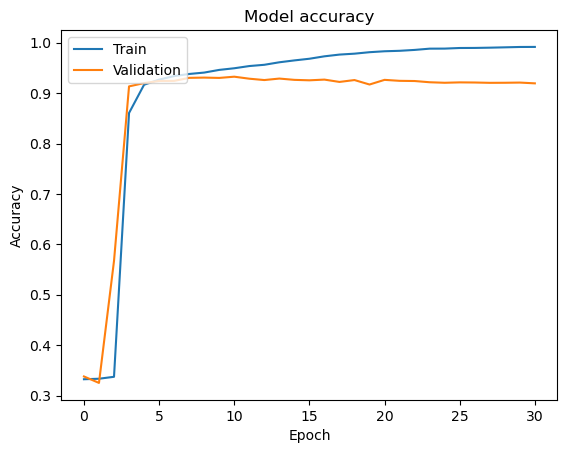

In [84]:
# Acc의 추이 확인
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

result_image_path = os.path.join(results_dir, 'acc_trends.png')
plt.savefig(result_image_path)

plt.show()

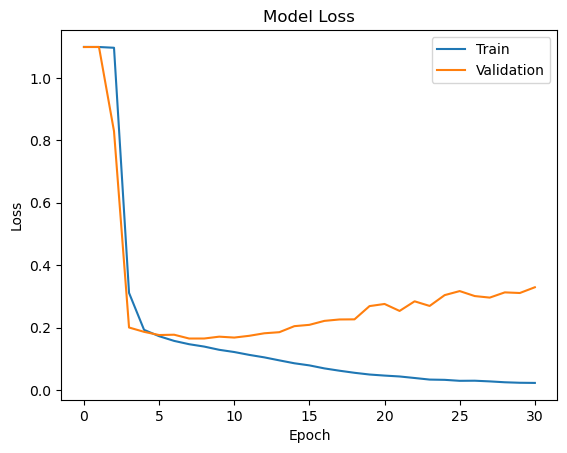

In [83]:
# 학습 손실과 검증 손실의 추이 확인
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

result_image_path = os.path.join(results_dir, 'loss_trends.png')
plt.savefig(result_image_path)

plt.show()

244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


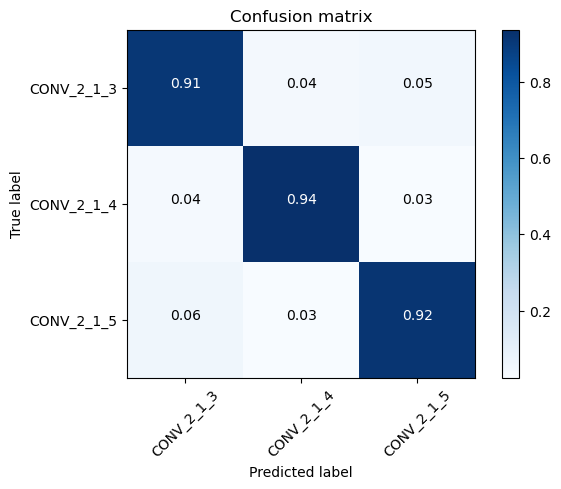

In [87]:
confnorm = calc_confusion_matrix(model_cnn, x_test)

# Plot confusion matrix
plot_confusion_matrix(confnorm, results_dir, labels=classes)


SNR -5dB:
10/10 - 0s - 6ms/step - accuracy: 0.4966 - loss: 2.1429

SNR -4dB:
11/11 - 0s - 6ms/step - accuracy: 0.5412 - loss: 1.8814

SNR -3dB:
10/10 - 0s - 6ms/step - accuracy: 0.6459 - loss: 1.3423

SNR -2dB:
9/9 - 0s - 6ms/step - accuracy: 0.7203 - loss: 1.0634

SNR -1dB:
10/10 - 0s - 6ms/step - accuracy: 0.7900 - loss: 0.7805

SNR 0dB:
10/10 - 0s - 6ms/step - accuracy: 0.8850 - loss: 0.3725

SNR 1dB:
10/10 - 0s - 6ms/step - accuracy: 0.9524 - loss: 0.1764

SNR 2dB:
10/10 - 0s - 6ms/step - accuracy: 0.9834 - loss: 0.0594

SNR 3dB:
10/10 - 0s - 6ms/step - accuracy: 0.9898 - loss: 0.0250

SNR 4dB:
9/9 - 0s - 6ms/step - accuracy: 1.0000 - loss: 2.6387e-06

SNR 5dB:
9/9 - 0s - 6ms/step - accuracy: 1.0000 - loss: 5.2073e-08

SNR 6dB:
9/9 - 0s - 6ms/step - accuracy: 1.0000 - loss: 0.0000e+00

SNR 7dB:
10/10 - 0s - 6ms/step - accuracy: 1.0000 - loss: 0.0000e+00

SNR 8dB:
10/10 - 0s - 6ms/step - accuracy: 1.0000 - loss: 0.0000e+00

SNR 9dB:
9/9 - 0s - 7ms/step - accuracy: 1.0000 - loss: 0.

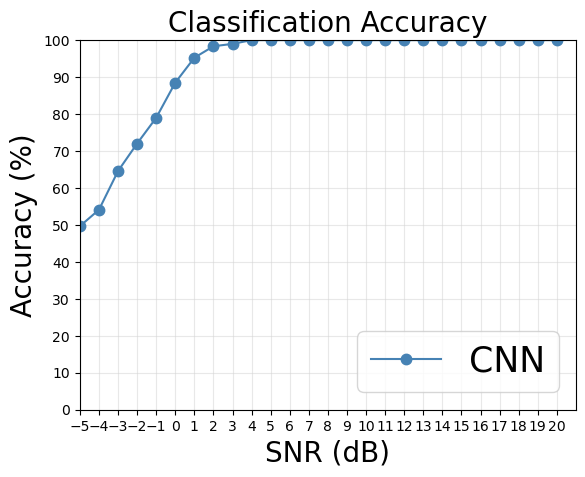

In [89]:
# Plot classfication accuracy by each SNR
acc = SNR_accuracy(snrs, model_cnn, 'CNN', x_test, y_test, results_dir)

In [47]:
acc = []
for snr in snrs:
    idx_acc_snr = [i for i in range(len(test_idx)) if lbl[test_idx[i]][1] == snr]
    acc_X_test = x_test[idx_acc_snr]
    acc_Y_test = y_test[idx_acc_snr]
    
    print('\nSNR ' + str(snr) + 'dB:')
    accuracy_snr = model_cnn.evaluate(acc_X_test, acc_Y_test, batch_size=128, verbose=2)
    acc.append(accuracy_snr)
acc = np.vstack(acc)


SNR -5dB:
2/2 - 0s - 10ms/step - accuracy: 0.4327 - loss: 1.5348

SNR -4dB:
2/2 - 0s - 11ms/step - accuracy: 0.5027 - loss: 1.2997

SNR -3dB:
2/2 - 0s - 11ms/step - accuracy: 0.5633 - loss: 1.1100

SNR -2dB:
2/2 - 0s - 11ms/step - accuracy: 0.6343 - loss: 1.0408

SNR -1dB:
2/2 - 0s - 11ms/step - accuracy: 0.6923 - loss: 0.7894

SNR 0dB:
2/2 - 0s - 11ms/step - accuracy: 0.7468 - loss: 0.6816

SNR 1dB:
2/2 - 0s - 10ms/step - accuracy: 0.9231 - loss: 0.2656

SNR 2dB:
2/2 - 0s - 10ms/step - accuracy: 0.9357 - loss: 0.1713

SNR 3dB:
2/2 - 0s - 10ms/step - accuracy: 0.9799 - loss: 0.0964

SNR 4dB:
1/1 - 0s - 18ms/step - accuracy: 0.9922 - loss: 0.0210

SNR 5dB:
2/2 - 0s - 10ms/step - accuracy: 1.0000 - loss: 3.4193e-04

SNR 6dB:
2/2 - 0s - 11ms/step - accuracy: 1.0000 - loss: 5.9695e-05

SNR 7dB:
2/2 - 0s - 10ms/step - accuracy: 1.0000 - loss: 5.6769e-06

SNR 8dB:
2/2 - 0s - 10ms/step - accuracy: 1.0000 - loss: 1.0185e-05

SNR 9dB:
2/2 - 0s - 10ms/step - accuracy: 1.0000 - loss: 1.1403e-06


In [57]:
print(acc[:, 1]) 

[0.43274853 0.50270271 0.56329113 0.63432837 0.69230771 0.74675328
 0.92307693 0.9357143  0.97986579 0.9921875  1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]
